In [84]:
import os
import logging
from dotenv import load_dotenv
from typing import Union
from dataclasses import dataclass

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdmolops, Draw


Molecule = Union[str, Chem.Mol]

logging.getLogger('rdkit').setLevel(logging.WARNING)

load_dotenv()
PROJECT_ROOT = os.getenv("PROJECT_ROOT")
DATA_DIR = PROJECT_ROOT + "/data/"

## Reading and preprocessing the dataset

In this section we read dataset and aggregate informaiton about molecule toxicity. Molecule is treated as toxic if at least 1 experiment colcluded that it is toxic. 

In [85]:
def is_toxic(row): 
    return int(any(row[1:])) 

data = pd.read_csv(DATA_DIR + "tox21.csv")
data.replace(np.nan, 0, inplace=True)
data['is_toxic'] = data.apply(is_toxic, axis=1)
data = data[['smiles', 'is_toxic']]

data

,smiles,is_toxic
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1
1,CCN1C(=O)NC(c2ccccc2)C1=O,0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,0
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0
...,...,...
7826,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,0
7827,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,1
7828,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,1
7829,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,1


## Preparing vectorisation methods

This section contains helper classes that would 

In [86]:
@dataclass
class Embedding: 
    """
    A class used to represent the Embedding of a graph.

    node_embeddings : np.ndarray
        An array representing the embeddings of the nodes in the graph.
    adjacency : np.ndarray
        An adjacency matrix representing the connections between nodes in the graph.
    degree : np.ndarray
        An array representing the degree of each node in the graph.
    laplacian : np.ndarray
        A Laplacian matrix derived from the adjacency matrix of the graph.
    edge_index : np.ndarray
        An array representing the indices of the edges in the graph.
    """
    node_embeddings: np.ndarray
    adjacency: np.ndarray
    degree: np.ndarray
    laplacian: np.ndarray
    edge_index: np.ndarray  
    
    def __str__(self):
        res = f"Node embeddings: {self.node_embeddings.shape}\n"
        res += f"Adjacency matrix: {self.adjacency.shape}\n"
        res += f"Degree matrix: {self.degree.shape}\n"
        res += f"Laplacian matrix: {self.laplacian.shape}\n"
        res += f"Edge index: {self.edge_index.shape}"
        
        return res 

class FeatureExtractor:
    MORGAN_RADIUS = 2
    MORGAN_NUM_BITS = 2048
    
    def __init__(self):
        self.mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
        
    
    def morgan_features_generator(self, mol: Molecule, radius: int = MORGAN_RADIUS, num_bits: int = MORGAN_NUM_BITS) -> np.ndarray:
        """
        Generates a Morgan fingerprint for a molecule.

        :param mol: A molecule (i.e., either a SMILES or an RDKit molecule).
        :param radius: Morgan fingerprint radius.
        :param num_bits: Number of bits in Morgan fingerprint.
        :return: A 2D numpy array containing the Morgan fingerprint for each atom in the molecule.
        """
        mol = Chem.MolFromSmiles(mol) if isinstance(mol, str) else mol
        features = np.zeros((mol.GetNumAtoms(), num_bits))

        for atom in range(mol.GetNumAtoms()):
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
            amap = {}
            submol = Chem.PathToSubmol(mol, env, atomMap=amap)
            Chem.GetSSSR(submol)
            # features_vec = AllChem.GetMorganFingerprintAsBitVect(submol, radius, nBits=num_bits)
            features_vec = self.mfpgen.GetFingerprint(submol)
            DataStructs.ConvertToNumpyArray(features_vec, features[atom])

        # (n_atoms, embedding_size)
        return features
    
    def mol_to_graph(self, molecule: Chem.Mol) -> np.ndarray:
        """
        Converts a molecule to its graph representation.
        
        :param molecule: (Chem.Mol or str): The molecule to convert. It can be either a RDKit Mol object or a SMILES string.
        :return np.ndarray: The adjacency matrix representing the graph of the molecule.
        """
        
        mol = Chem.MolFromSmiles(molecule) if isinstance(molecule, str) else molecule
        graph = rdmolops.GetAdjacencyMatrix(mol)
        
        # (n_atoms, n_atoms)
        return graph
    
    def molecule_show(selff, molecule, title=False):
        """
        Displays a visual representation of a molecule from its SMILES string.
        
        :param molecule: (str): The SMILES string representation of the molecule.
        :param title: (bool, optional): If True, displays the SMILES string as the title of the plot. Defaults to False.
        """
        
        m = Chem.MolFromSmiles(molecule)
        img = Draw.MolToImage(m)
        
        if title: 
            plt.title(molecule)
    
        plt.imshow(img)
    
    def __call__(self, molecule: Molecule): 
        """
        Makes an embeddings of a molecule. 
        
        :param molecule: (str): The SMILES string representation of the molecule.
        :return Embedding: The embeddings of the molecule.
        """
        
        node_embeddings = self.morgan_features_generator(molecule, self.MORGAN_RADIUS, self.MORGAN_NUM_BITS)
        adjacency = self.mol_to_graph(molecule)
        degree = np.diag(np.sum(adjacency, axis=1))
        laplacian = degree - adjacency
        edge_index = np.array(np.nonzero(adjacency))

        return Embedding(node_embeddings, adjacency, degree, laplacian, edge_index)

feature_extractor = FeatureExtractor()

Molecule: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
Node embeddings: (16, 2048)
Adjacency matrix: (16, 16)
Degree matrix: (16, 16)
Laplacian matrix: (16, 16)
Edge index: (2, 34)


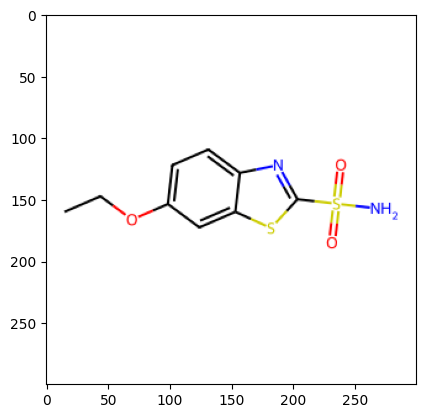

Molecule: CCN1C(=O)NC(c2ccccc2)C1=O
Node embeddings: (15, 2048)
Adjacency matrix: (15, 15)
Degree matrix: (15, 15)
Laplacian matrix: (15, 15)
Edge index: (2, 32)


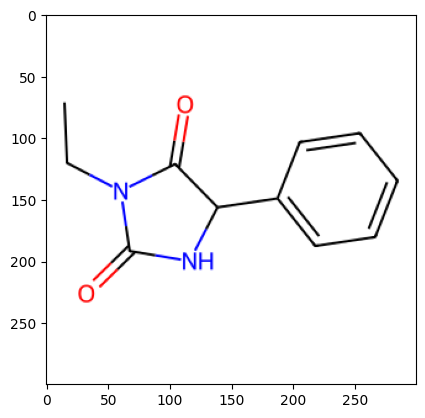

Molecule: CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C
Node embeddings: (21, 2048)
Adjacency matrix: (21, 21)
Degree matrix: (21, 21)
Laplacian matrix: (21, 21)
Edge index: (2, 48)


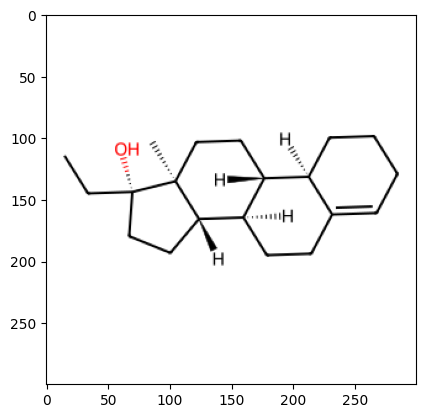

Molecule: CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
Node embeddings: (20, 2048)
Adjacency matrix: (20, 20)
Degree matrix: (20, 20)
Laplacian matrix: (20, 20)
Edge index: (2, 40)


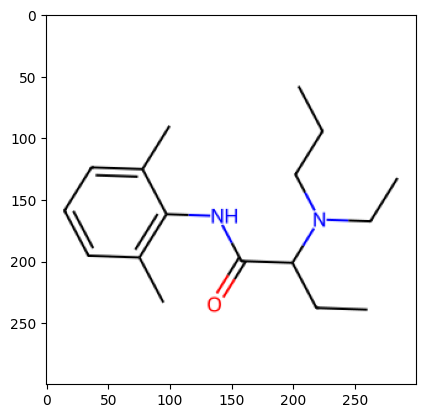

Molecule: CC(O)(P(=O)(O)O)P(=O)(O)O
Node embeddings: (11, 2048)
Adjacency matrix: (11, 11)
Degree matrix: (11, 11)
Laplacian matrix: (11, 11)
Edge index: (2, 20)


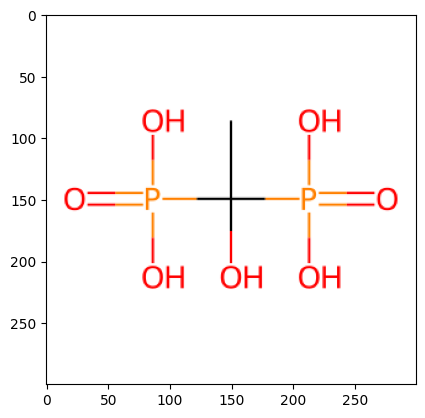

In [87]:
for molecule in data.iloc[:5, 0]: 
    feature_extractor.molecule_show(molecule, title=False)
    embedding = feature_extractor(molecule)
    
    print("Molecule:", molecule)
    print(embedding)
    plt.show()

## Data distributions

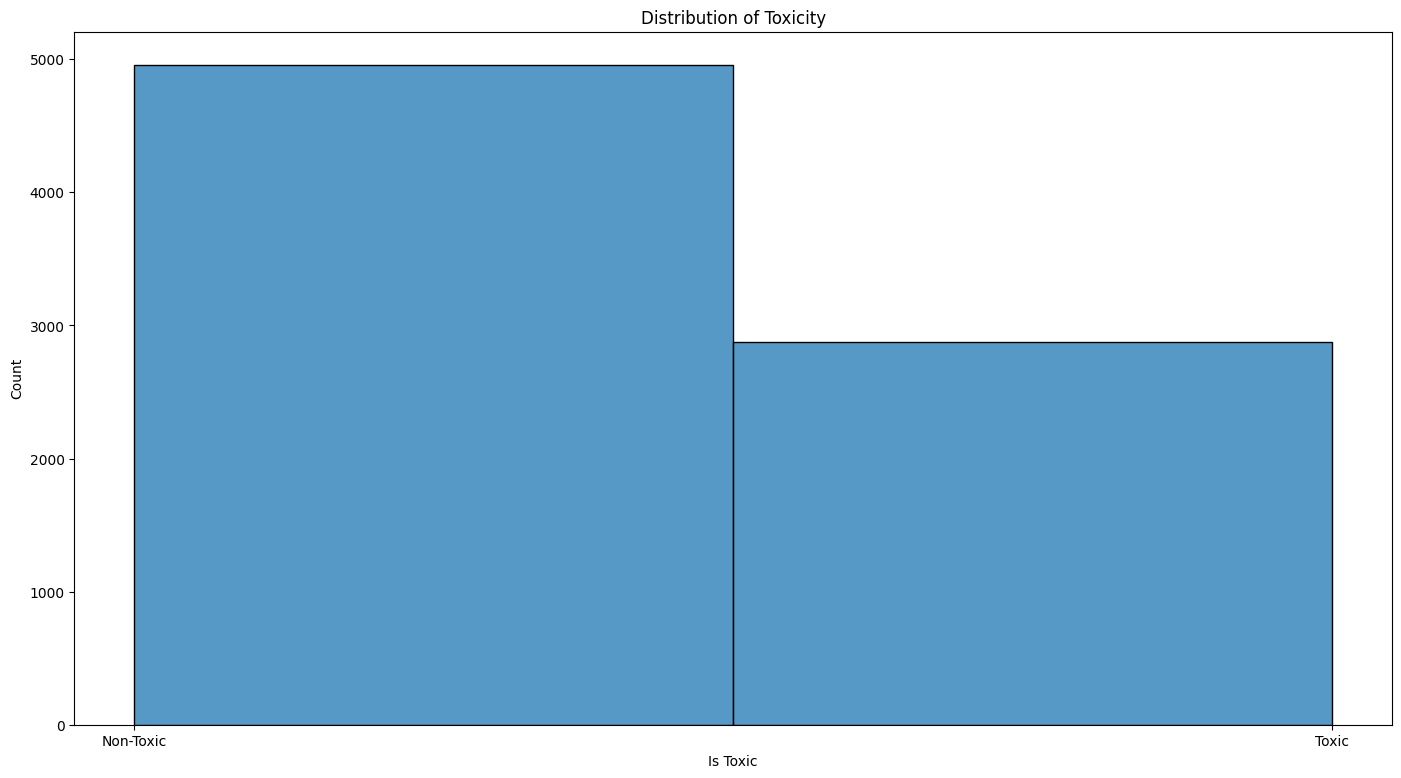

In [88]:
plt.figure(figsize=(17, 9))
sns.histplot(data['is_toxic'], bins=2, kde=False)
plt.title('Distribution of Toxicity')
plt.xlabel('Is Toxic')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
plt.show()

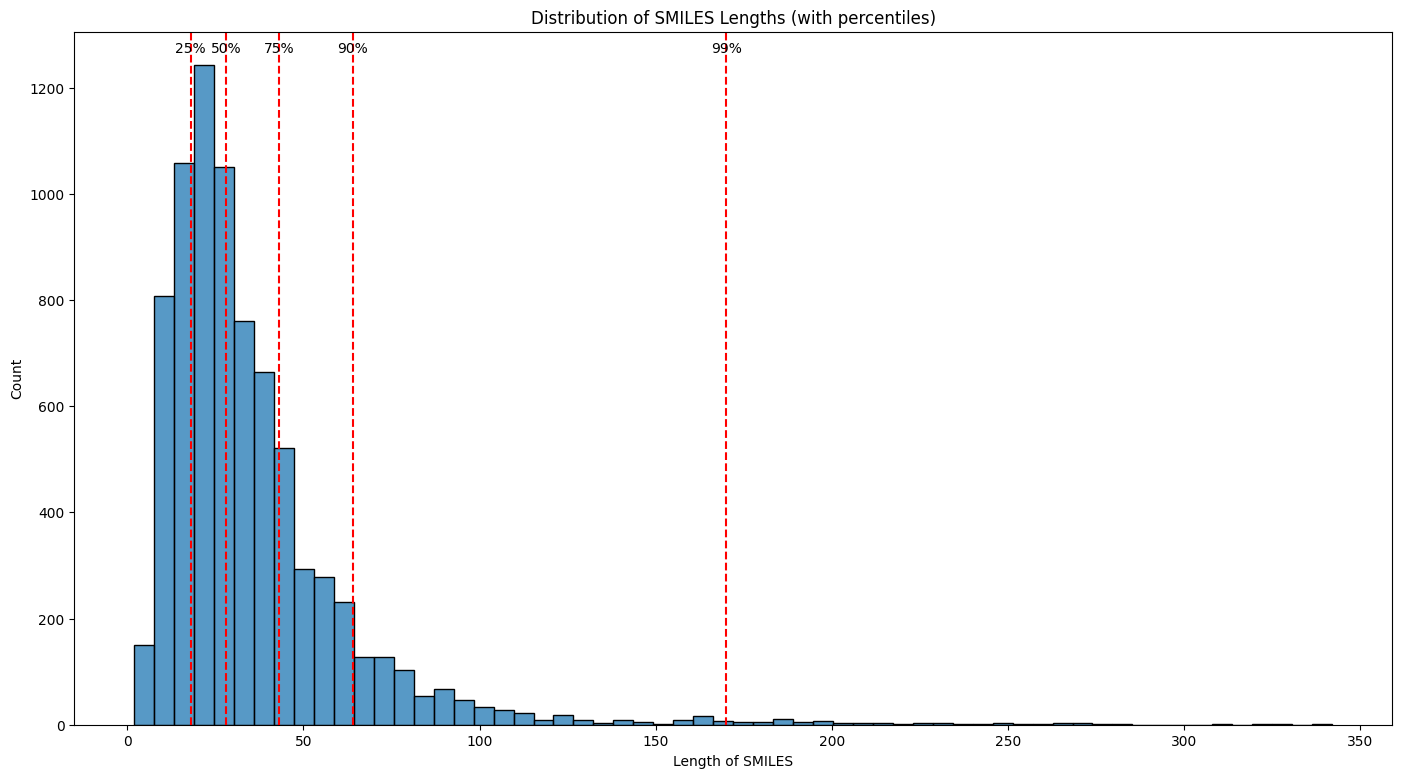

In [89]:
plt.figure(figsize=(17, 9))

distribution = data['smiles'].apply(len)
sns.histplot(data['smiles'].apply(len), bins=60, kde=False)
plt.title('Distribution of SMILES Lengths (with percentiles)')

percentiles = [25, 50, 75, 90, 99]  # Define the percentiles to be used for the vertical lines
for percentile in percentiles:
    value = data['smiles'].apply(len).quantile(percentile / 100)
    plt.axvline(x=value, color='red', linestyle='--')
    plt.text(value, plt.ylim()[1] * 0.97, f'{percentile}%', color='black', ha='center')
    
    
plt.xlabel('Length of SMILES')
plt.ylabel('Count')
plt.show()

[22:30:52] WARNING: not removing hydrogen atom without neighbors
[22:30:52] WARNING: not removing hydrogen atom without neighbors


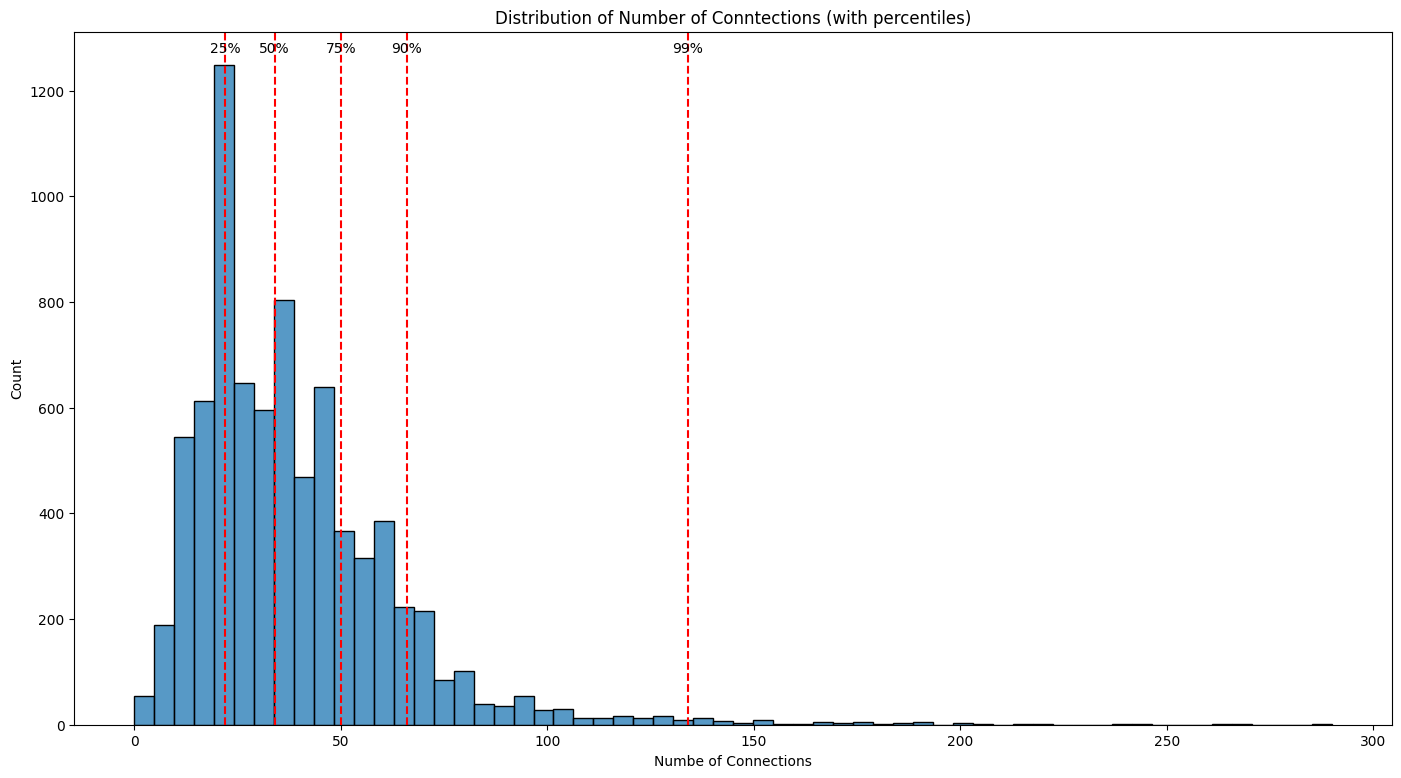

In [90]:
def n_atoms(row): 
    embedding = feature_extractor(row) 
    return embedding.edge_index.shape[1]

plt.figure(figsize=(17, 9))

distribution = data['smiles'].apply(n_atoms)
sns.histplot(distribution, bins=60, kde=False)
plt.title('Distribution of Number of Conntections (with percentiles)')

percentiles = [25, 50, 75, 90, 99]  # Define the percentiles to be used for the vertical lines
for percentile in percentiles:
    value = distribution.quantile(percentile / 100)
    plt.axvline(x=value, color='red', linestyle='--')
    plt.text(value, plt.ylim()[1] * 0.97, f'{percentile}%', color='black', ha='center')
    
plt.xlabel('Number of Connections')
plt.ylabel('Count')
plt.show()